<a href="https://www.kaggle.com/code/priyankapalshetkar/spaceship-titanic-score-0-8?scriptVersionId=118033750" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## Imports and Setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

In [3]:
SEED = 42

def seed_everything(seed = 42):
    import random, os
    import numpy as np

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [4]:
train_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

## Data Fields Information:
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Data Study

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train_df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


### Some Prior Observations/points to explore:
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck are related to CryoSleep because if the passenger has elected to be put in suspended animation, they would not spend money on these amenities.
* CryoSleep and Cabin could be related i.e. passengers in CryoSleep could be in a particular section of the ship?
* VIP and CryoSleep could also be related the same way as RoomService, FoodCourt, ShoppingMall, Spa, VRDeck because why would a passenger pay for special VIP service if they are going to be in CryoSleep?
* HomePlanet and Destination might also be related as people from a particular home planet might plan to go to the same destination?

## Missing Values

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


<AxesSubplot:>

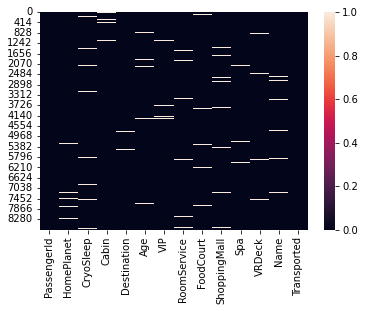

In [7]:
print(train_df.isnull().sum().sort_values(ascending=False))
sns.heatmap(train_df.isnull())

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


<AxesSubplot:>

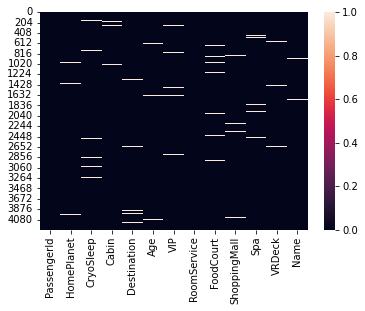

In [8]:
print(test_df.isnull().sum().sort_values(ascending=False))
sns.heatmap(test_df.isnull())

In [9]:
def wrangle(df):
    
    # Split Cabin column into deck/num/side
    df[["Cabin_deck", "Cabin_num", "Cabin_side"]] = df["Cabin"].str.split("/", expand = True)
    
    # Create a new column Passenger Group from PassengerId
    df["Passenger_Group"] = df["PassengerId"].str.split("_", expand=True)[0].astype(int)
    
    # Drop name column
    df.drop(columns="Name", inplace=True)
    
    # Fill in missing values
    
    df["CryoSleep"].fillna("False", inplace = True)
    df["VIP"].fillna("False", inplace = True)
    df["CryoSleep"] = df["CryoSleep"].astype(bool)
    df["VIP"] = df["VIP"].astype(bool)
    df["HomePlanet"].fillna("Earth", inplace = True)
    df["Destination"].fillna("TRAPPIST-1e", inplace = True)
    df["Age"].fillna(df["Age"].median(), inplace=True)
    
    for col in ["Cabin_deck", "Cabin_side"]:
        df[col].fillna("Unknown", inplace = True)
        
    for col in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
        df.loc[df[col].isna() & df["CryoSleep"] == True, col] = 0
        df[col].fillna(df[col].median(), inplace=True)
    
    # Create a new column Spending Level from RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
    total_spending = df["RoomService"] + df["FoodCourt"] + df["ShoppingMall"] + df["Spa"] + df["VRDeck"]
    df["Spending_Level"] = pd.cut(x=total_spending, bins=[-1,0,2500,5000,100000], labels=['None','Low','Moderate','High'])
    
#     # Create a new column Age Group
#     df['Age_Group'] = pd.cut(df["Age"],bins=[0, 5, 12, 18, 50, 150], labels=['Baby','Child','Teen', 'Adult','Elderly'])
    
    # Dropping not needed columns
    df.drop(columns=["Cabin", "Cabin_num", "PassengerId"], inplace = True)
    
    return df

In [10]:
train_df = wrangle(train_df)
test_df = wrangle(test_df)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   HomePlanet       8693 non-null   object  
 1   CryoSleep        8693 non-null   bool    
 2   Destination      8693 non-null   object  
 3   Age              8693 non-null   float64 
 4   VIP              8693 non-null   bool    
 5   RoomService      8693 non-null   float64 
 6   FoodCourt        8693 non-null   float64 
 7   ShoppingMall     8693 non-null   float64 
 8   Spa              8693 non-null   float64 
 9   VRDeck           8693 non-null   float64 
 10  Transported      8693 non-null   bool    
 11  Cabin_deck       8693 non-null   object  
 12  Cabin_side       8693 non-null   object  
 13  Passenger_Group  8693 non-null   int64   
 14  Spending_Level   8693 non-null   category
dtypes: bool(3), category(1), float64(6), int64(1), object(4)
memory usage: 781.3+ KB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   HomePlanet       4277 non-null   object  
 1   CryoSleep        4277 non-null   bool    
 2   Destination      4277 non-null   object  
 3   Age              4277 non-null   float64 
 4   VIP              4277 non-null   bool    
 5   RoomService      4277 non-null   float64 
 6   FoodCourt        4277 non-null   float64 
 7   ShoppingMall     4277 non-null   float64 
 8   Spa              4277 non-null   float64 
 9   VRDeck           4277 non-null   float64 
 10  Cabin_deck       4277 non-null   object  
 11  Cabin_side       4277 non-null   object  
 12  Passenger_Group  4277 non-null   int64   
 13  Spending_Level   4277 non-null   category
dtypes: bool(2), category(1), float64(6), int64(1), object(4)
memory usage: 380.4+ KB


## Analysis of Categorical Data

In [13]:
def countplots(*args):
    for i in args:
        fig, ax = plt.subplots(figsize=(15,6), nrows = 1, ncols = 1)
        sns.countplot(x = i, data = train_df)

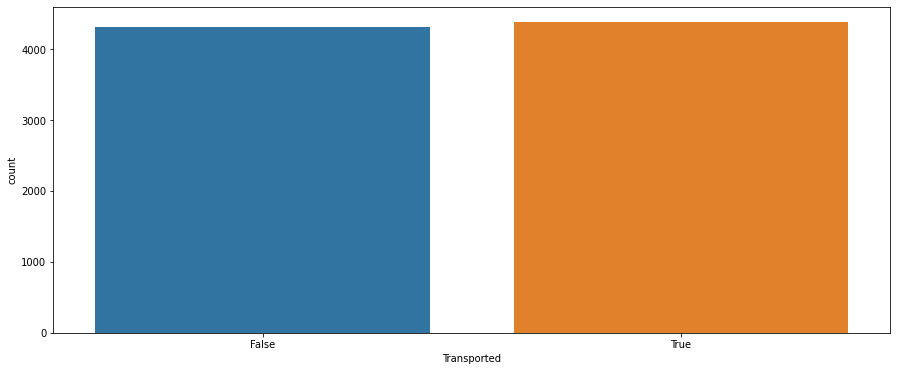

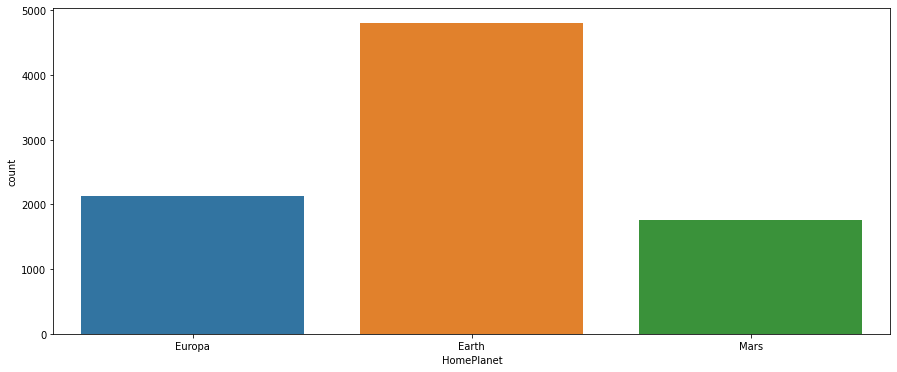

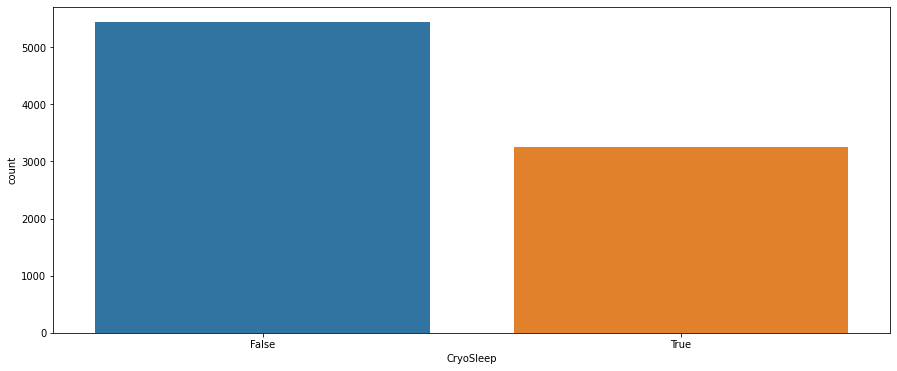

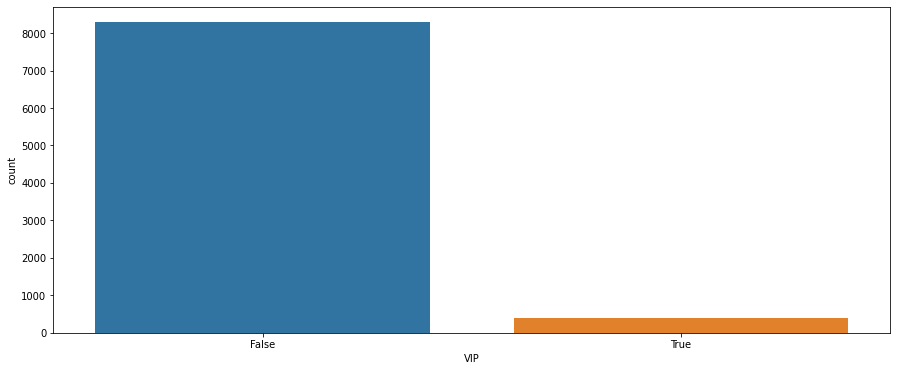

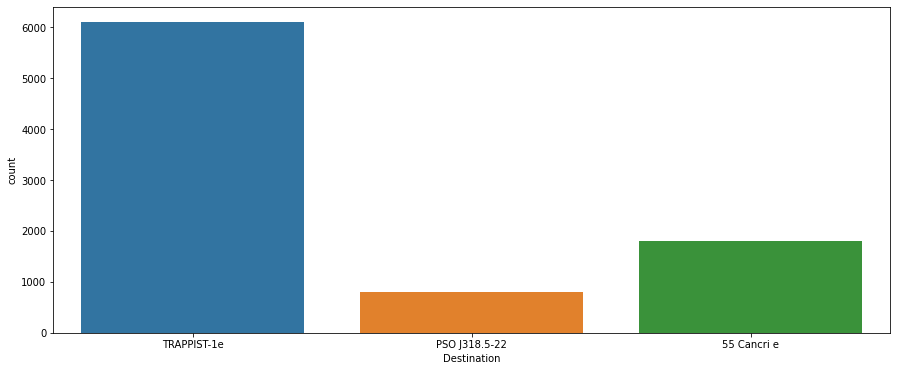

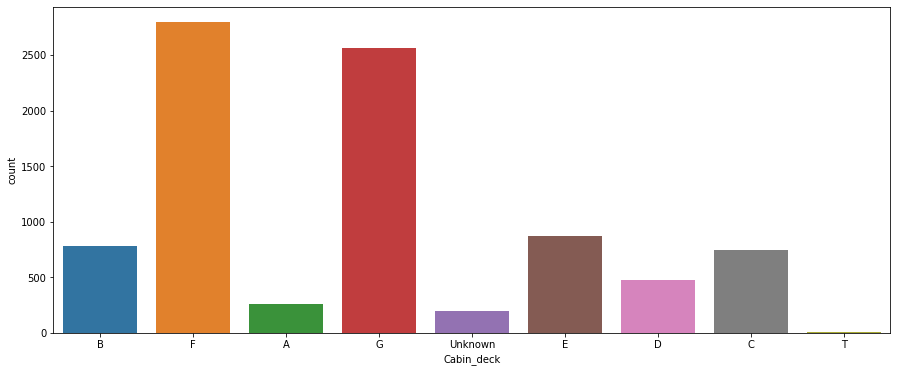

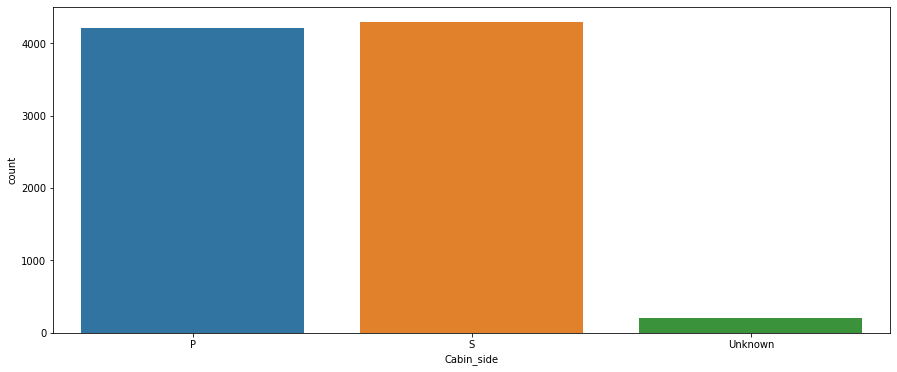

In [14]:
countplots('Transported', 'HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'Cabin_deck', 'Cabin_side')

## Encoding of Categorical Variables

In [15]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Age']
cat_cols = ['CryoSleep','Cabin_deck','Cabin_side','VIP','HomePlanet','Destination', 'Spending_Level']

In [16]:
def encoder(df):
    num_imp = SimpleImputer(strategy='mean')
    cat_imp = SimpleImputer(strategy='most_frequent')
    ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)


    df[num_cols] = pd.DataFrame(num_imp.fit_transform(df[num_cols]),columns=num_cols)
    df[cat_cols] = pd.DataFrame(cat_imp.fit_transform(df[cat_cols]),columns=cat_cols)
    temp_train = pd.DataFrame(ohe.fit_transform(df[cat_cols]),columns= ohe.get_feature_names_out())
    df = df.drop(cat_cols,axis=1)
    df = pd.concat([df,temp_train],axis=1)
    
    return df

In [17]:
train_df = encoder(train_df)
test_df = encoder(test_df)

In [18]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   bool   
 7   Passenger_Group            8693 non-null   int64  
 8   CryoSleep_False            8693 non-null   float64
 9   CryoSleep_True             8693 non-null   float64
 10  Cabin_deck_A               8693 non-null   float64
 11  Cabin_deck_B               8693 non-null   float64
 12  Cabin_deck_C               8693 non-null   float64
 13  Cabin_deck_D               8693 non-null   float

## Train-Test Split

In [19]:
X = train_df.drop(columns=['Transported'])
print(X.shape)
y = train_df.Transported.astype('int')
print(y.shape)

(8693, 33)
(8693,)


In [20]:
from sklearn.utils import shuffle

X,y = shuffle(X,y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,
                                                        test_size=0.1, 
                                                        stratify=y, 
                                                        random_state=SEED)

## Model Training - CatBoost

In [22]:
catboost_grid = {'depth': [6], 'iterations': [1000],
                         'l2_leaf_reg': [0.05],
                         'learning_rate': [0.01]}

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

catboost_model = CatBoostClassifier(verbose = False, use_best_model=True)
catboost_grid_res = GridSearchCV(catboost_model, catboost_grid, cv=3 ,scoring='accuracy').fit(X_train, y_train, eval_set=(X_valid, y_valid))
best_catboost_model = catboost_grid_res.best_estimator_
catboost_predict = best_catboost_model.predict(X_valid)

In [24]:
catboost_grid_res.best_params_

{'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 0.05, 'learning_rate': 0.01}

## Inference

In [25]:
XTest = test_df

In [26]:
XTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        4277 non-null   float64
 1   RoomService                4277 non-null   float64
 2   FoodCourt                  4277 non-null   float64
 3   ShoppingMall               4277 non-null   float64
 4   Spa                        4277 non-null   float64
 5   VRDeck                     4277 non-null   float64
 6   Passenger_Group            4277 non-null   int64  
 7   CryoSleep_False            4277 non-null   float64
 8   CryoSleep_True             4277 non-null   float64
 9   Cabin_deck_A               4277 non-null   float64
 10  Cabin_deck_B               4277 non-null   float64
 11  Cabin_deck_C               4277 non-null   float64
 12  Cabin_deck_D               4277 non-null   float64
 13  Cabin_deck_E               4277 non-null   float

In [27]:
# ytest_pred = trained_models['random_forest']['model'].predict(XTest)
ytest_pred = best_catboost_model.predict(XTest)

In [28]:
output = sample_submission.copy()
output['Transported'] = ytest_pred.astype(bool)
output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [29]:
output.to_csv('./solution.csv', index=False)